V tem "notebooku" bom poskusil izdelati ti. "Credit default" model, ki bo iz danih podatkov o komitentih (najemnikih posojila) napovedal, ali bo slednji dolg odplačal ali ne. Podatke sem pridobil z naslednje spletne strani: https://www.kaggle.com/wendykan/lending-club-loan-data

In [2]:
#install.packages('ggplot2', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('rvest', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('gsubfn', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('readr', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('dplyr', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('readxl', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('randomForest', dependencies = TRUE, repos = "http://cran.us.r-project.org")

library(ggplot2)
library(rvest)
library(gsubfn)
library(readr)
library(dplyr)
library(readxl)
library(randomForest)

In [3]:
#install.packages('maptools', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages("sp", dependencies =TRUE, repos = "http://cran.us.r-project.org")

library(sp)
library(maptools)

# Obdelava, uvoz in čiščenje podatkov

Uvoženi podatki se nahajajo v dveh tabelah. Prva tabela vsebuje spremenljivke in njihove opise (pomene). V drugi (glavni) so zbrani podatki o posameznih najemnikih posojil. Gre za ogromno podatkovno zbirko, saj obsega podatke o kar slabih 900.000 osebah, pri vsaki pa je shranjenih 74 spremenljivk.

Podatki so že v "tidy-data" obliki, niso pa še pripravljeni za nadaljnjo analizo (prevelika količina spremenljivk za učinkovito in pregledno delo). Prva faza bo tako obsegala izbor najpomembnejših spremenljivk (želeno število je okoli 20). Za lažje delo v nadaljevanju bom tudi zmanjšal število komitentov v bazi (sam uvoz celotnih podatkov je namreč trajal cca 5 minut) na približno 80.000, kar predstavlja 10% začetnih podatkov.

In [9]:
info = read_excel("filesCredit/LCDataDictionary.xlsx")

In [13]:
head(info)

LoanStatNew,Description
addr_state,The state provided by the borrower in the loan application
annual_inc,The self-reported annual income provided by the borrower during registration.
annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
collection_recovery_fee,post charge off collection fee
collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections


In [8]:
#datoteka loan.csv se ne nahaja več v tem repozitoriju (prevelika datoteka, da bi jo naložil na github)
loadData = read.csv("loan.csv", header=T)

In [33]:
head(loadData)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1075358,1311748,3000,3000,3000,60 months,12.69,67.79,B,B5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [18]:
dim(loadData)

[1] 887379     74

Pri izbiri spremenljivk si pomagam s fukncijo str(loadData), ki mi izpiše podrobnejše informacije o posameznih spremenljivkah. Nekaj razlogov za odstranitev posameznih spremenljivk:
- "emp_title", "url", "desc" ... : pri vseh gre za to, da so prevelike oz. preveč specifične za smiselno analizo ("emp_title" tako vsebuje kar slabih 300.000 različnih vnosov).
- "member_id", "revol_bal", "funded_amnt" ... : informacije so zajete že v drugih spremenljivkah, ne doprinesejo bistveno novih informacij k celoti ("funded_amnt" se od "loan_amnt" v povprečju razlikuje za samo 13$).
- "pymnt_plan", "application_type" : binarne spremenljivke. Od tega manj kot 0,5% vnosov pripada enemu razredu, tako da so praktično vse spremenljivke v istem razredu.
- "tot_coll_amt", "tot_cur_bal", "open_acc_6m" ... : večina vnosov je NA.

In [19]:
str(loadData)

'data.frame':	887379 obs. of  74 variables:
 $ id                         : int  1077501 1077430 1077175 1076863 1075358 1075269 1069639 1072053 1071795 1071570 ...
 $ member_id                  : int  1296599 1314167 1313524 1277178 1311748 1311441 1304742 1288686 1306957 1306721 ...
 $ loan_amnt                  : num  5000 2500 2400 10000 3000 ...
 $ funded_amnt                : num  5000 2500 2400 10000 3000 ...
 $ funded_amnt_inv            : num  4975 2500 2400 10000 3000 ...
 $ term                       : Factor w/ 2 levels " 36 months"," 60 months": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate                   : num  10.6 15.3 16 13.5 12.7 ...
 $ installment                : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                      : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ sub_grade                  : Factor w/ 35 levels "A1","A2","A3",..: 7 14 15 11 10 4 15 21 27 10 ...
 $ emp_title                  : Factor w/ 299273 levels "","'Property Manager",..

In [22]:
mean(abs(loadData$loan_amnt - loadData$funded_amnt))
mean(abs(loadData$loan_amnt - loadData$funded_amnt_inv))
mean(loadData$loan_amnt)

[1] 13.38698

[1] 52.80022

[1] 14755.26

In [25]:
sum(loadData$pymnt_plan == 'n')

[1] 887369

In [35]:
mean(abs(loadData$out_prncp - loadData$out_prncp_inv))

[1] 3.41161

In [36]:
sum(loadData$total_rec_late_fee)

[1] 352016

In [38]:
sum(loadData$application_type == 'JOINT')

[1] 511

In [9]:
downsampl <- loadData[sample(nrow(loadData), 80000), ]

In [10]:
downsampl <- downsampl[,c("id", "loan_amnt", "int_rate", "installment", "grade", "sub_grade", "emp_length", "home_ownership", 
                    "annual_inc", "verification_status", "issue_d", "purpose", "addr_state", "dti", "open_acc", 
                    "revol_util", "total_acc", "out_prncp", "total_pymnt", "total_rec_late_fee", "last_pymnt_d", "loan_status")]

Sedaj dobim tabelo dimenzije 80.000 x 21. Podatki so v pravi obliki (za vsakega komitenta je shranjenih najpomembnejših 21 spremenljivk). Na koncu tabelo shranim v "loanDownsample.csv". 

In [28]:
dim(downsampl)

[1] 80000    21

In [26]:
rownames(downsampl) <- downsampl$id
downsampl$id <- NULL
head(downsampl)

,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,addr_state,dti,open_acc,revol_util,total_acc,out_prncp,total_pymnt,total_rec_late_fee,last_pymnt_d,loan_status
66370404,3500,10.64,113.99,B,B4,2 years,RENT,42000,Source Verified,Dec-2015,...,FL,24.43,9,38.6,32,3417.04,111.92,0,Jan-2016,Current
56019943,2575,17.57,92.54,D,D4,10+ years,RENT,36000,Verified,Jul-2015,...,TX,13.67,6,14.5,7,2292.66,457.67,0,Dec-2015,Current
63518390,5275,21.99,201.43,F,F1,10+ years,MORTGAGE,52000,Verified,Oct-2015,...,MO,22.36,8,57.0,9,5063.55,396.42,0,Dec-2015,Current
14600061,15000,19.47,553.42,D,D5,< 1 year,OWN,80000,Verified,Apr-2014,...,VA,28.97,24,68.8,41,0.00,16942.03,0,Dec-2014,Fully Paid
48474794,31000,13.99,721.16,C,C4,10+ years,RENT,86147,Verified,May-2015,...,TX,12.12,7,72.0,14,28001.77,5745.19,0,Jan-2016,Current
40433030,24000,17.14,598.27,D,D4,7 years,MORTGAGE,68000,Source Verified,Feb-2015,...,UT,22.01,9,52.9,22,20980.29,6558.12,0,Jan-2016,Current


In [27]:
write.csv(downsampl, file = "filesCredit/loanDownsample.csv")

# Analiza in vizualizacija podatkov

Pri preliminarni raziskovalni analizi si bom pomagal s knjižnico "DescTools", ki omogoča enostaven prikaz porazdelitev posameznih spremenljivk.

In [23]:
install.packages('DescTools', dependencies = TRUE, repos = "http://cran.us.r-project.org")
library(DescTools)

Najprej preverim porazdelitev "Loan status". Tu so namreč zbrane informacije o zamudnikih, tj. tistih ki imajo težave pri odplačevanju kredita. Ravno te spremenljivke bom kasneje poskusil napovedati.

Vidim, da gre za primer "unbalanced data". Razredi, ki predstavljajo "težave" (Late, Default, Charged Off), tako skupaj predstavljajo le dobrih 7% celotnih podatkov. 

------------------------------------------------------------------------------ 
Loan status

  length      n    NAs unique levels  dupes
  80'000 80'000      0     10     10      y
         100.0%   0.0%                     

                                                  level    freq   perc  cumfreq  cumperc
1                                               Current  54'128  67.7%   54'128    67.7%
2                                            Fully Paid  18'681  23.4%   72'809    91.0%
3                                           Charged Off   4'215   5.3%   77'024    96.3%
4                                    Late (31-120 days)   1'086   1.4%   78'110    97.6%
5                                                Issued     757   0.9%   78'867    98.6%
6                                       In Grace Period     579   0.7%   79'446    99.3%
7                                     Late (16-30 days)     206   0.3%   79'652    99.6%
8    Does not meet the credit policy. Status:Fully Paid     16

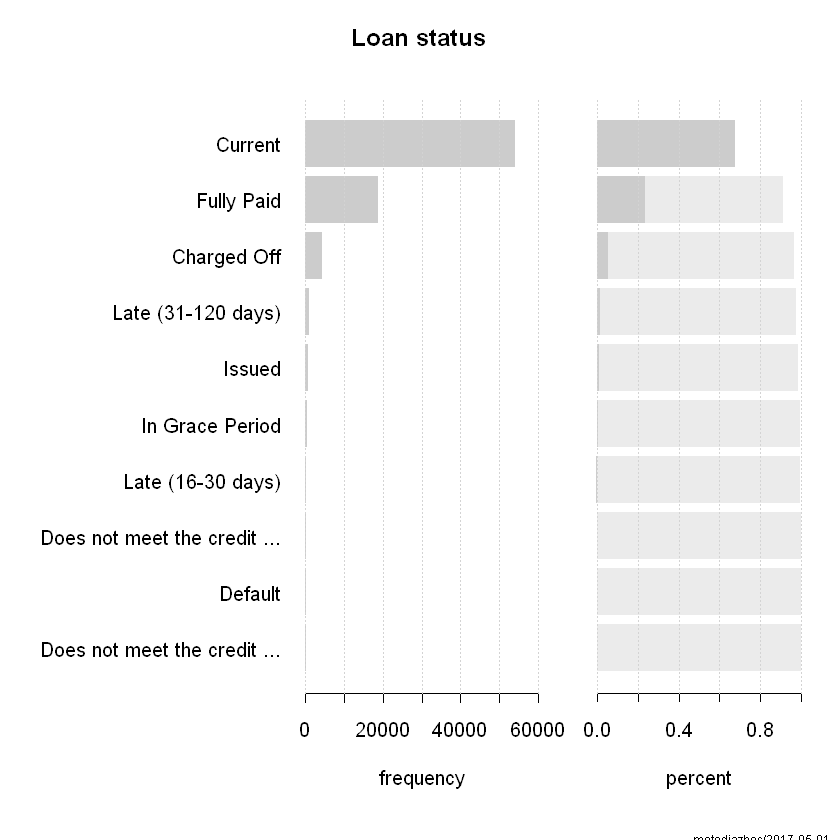

In [31]:
Desc(downsampl$loan_status, main = "Loan status", plotit = T)

Izračunam lahko še povprečni dohodek po kategorijah spremenljivke "loan_status". Vidim, da so rezultati pričakovani. Dolžniki, ki zamujajo ali pri katerih je prišlo do "default-a", imajo v povprečju nižji dohodek. Podobno storim še za obrestno mero in ponovno vidim, da imajo "slabši" najemniki posojila v povprečju višjo obrestno mero (kar je pričakovano, saj banka želi višjo premijo za tveganje).

In [7]:
povprecni_dohodek <- downsampl %>% select(annual_inc, loan_status) %>% 
                        group_by(loan_status) %>% summarise(povpr_dohodek = mean(annual_inc))
povprecni_dohodek <- povprecni_dohodek[with(povprecni_dohodek, order(povpr_dohodek)), ]
#povprecni_dohodek

obrestna <- downsampl %>% select(int_rate, loan_status) %>% 
                        group_by(loan_status) %>% summarise(obr_mera = mean(int_rate))
obrestna <- obrestna[with(obrestna, order(obr_mera)), ]
#obrestna

primer <- merge(povprecni_dohodek, obrestna, by = "loan_status")
primer

loan_status,povpr_dohodek,obr_mera
Charged Off,64714.12,16.11120
Current,76088.21,12.98617
Default,66062.83,16.18345
Does not meet the credit policy. Status:Charged Off,63030.30,14.64195
Does not meet the credit policy. Status:Fully Paid,74186.34,14.03267
Fully Paid,73868.48,13.31570
In Grace Period,72291.44,15.55974
Issued,77725.93,12.55231
Late (16-30 days),72190.86,15.95917
Late (31-120 days),70509.98,15.88438


TO DO: ugotoviti, kako na smiselen način prikazati spremenljivki "dolg" in "razred_plac" hkrati na zemljevidu

Checking rgeos availability: TRUE
Warning message:
"use rgdal::readOGR or sf::st_read"Warning message:
"use rgdal::readOGR or sf::st_read"Regions defined for each Polygons


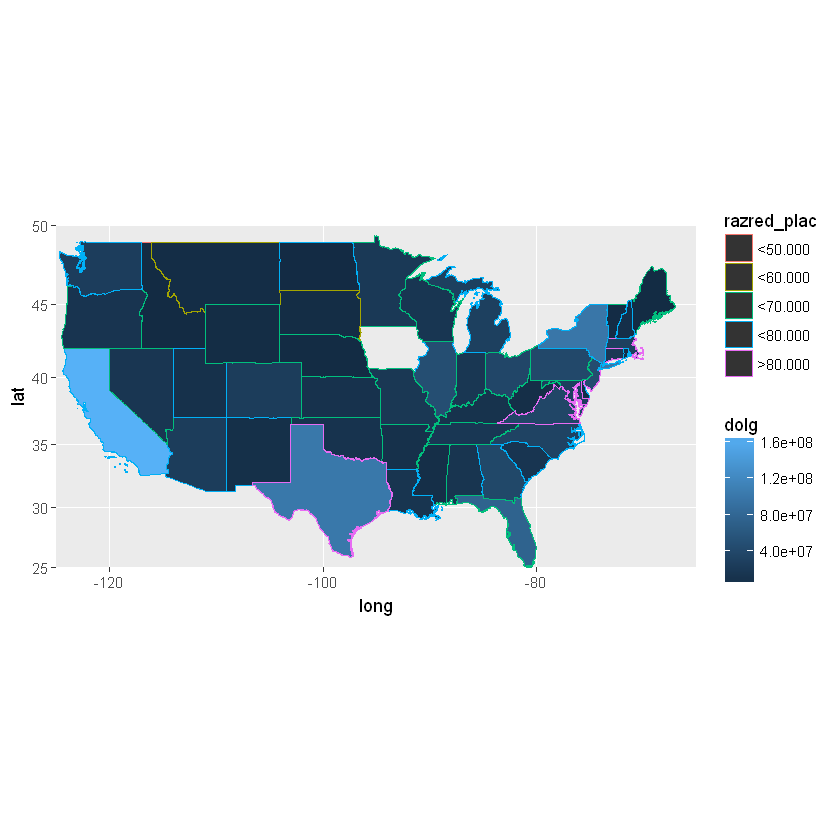

In [30]:
source("https://raw.githubusercontent.com/jaanos/APPR-2017/master/lib/uvozi.zemljevid.r")

zda <- uvozi.zemljevid("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip",
                          "cb_2016_us_state_500k", encoding = "Windows-1250") %>% pretvori.zemljevid()

#ggplot() + geom_polygon(data = zda, aes(x = long, y = lat, group = group, fill = id)) +
#        guides(fill = FALSE) + coord_map(xlim = c(-125, -65),ylim = c(25, 50))

skupaj <- data %>% select(addr_state, loan_amnt, annual_inc) %>% 
    group_by(addr_state) %>% summarise(dolg = sum(loan_amnt), povpr_dohodek=mean(annual_inc))

zda$STUSPS <- parse_character(zda$STUSPS)

tmp <- inner_join(zda, skupaj, by = c("STUSPS" = "addr_state"))

tmp <- tmp %>% mutate(razred_plac = ifelse(povpr_dohodek < 50000, "<50.000", 
                        ifelse(povpr_dohodek < 60000, "<60.000", ifelse(povpr_dohodek < 70000, "<70.000", 
                        ifelse(povpr_dohodek < 80000, "<80.000", ">80.000")))))


ggplot() + geom_polygon(data = tmp, aes(x = long, y = lat, group = group, fill = dolg, colour = razred_plac)) + coord_map(xlim = c(-125, -65),ylim = c(25, 50))

# Napredna analiza podatkov

V tem sklopu projektne naloge bom uporabil "machine learning" algoritem Random forest. Gre za znan model, ki v ozadju uporablja odločitvena drevesa, in je primeren za nalogi klasifikacije in regresije. 

Naprej bom poskušal iz danih podatkov napovedati spremenljivko loan_status. Ker ima ta spremenljivka 10 različnih razredov, od katerih so nekateri zastopani v zelo majhnem številu, sem se odločil, da spremelnjivko posplošim. Tabeli sem dodal nov stolpec "stanje", ki ima tri razrede. V prvi razred "good" sem dal vse tipe spremenljivke loan_status, ki kažejo na to, da komitent redno odplačuje kredit oz. ga je že odplačal. Preostala dva razreda sta še "bad" in "other", pri čemer sem v slednjega dal tipa "In grace period" in "Issued". Pri te-dveh namreč nisem bil prepričan, v katerega od prvih dveh razredov bi ju vmestil.  

In [5]:
data <- read_csv("filesCredit/loanDownsample.csv")
downsample <- data[sample(nrow(data), 15000), ]
downsample <- downsample[,2:22]

In [6]:
en <- locale("en", date_format = "%b-%Y", decimal_mark = ".", grouping_mark = ",")

downsample <- downsample %>% mutate(stanje = ifelse(loan_status == 'Current' | loan_status == 'Fully Paid' | loan_status == 'Does not meet the credit policy. Status:Fully Paid', 'Good', 
ifelse(loan_status == 'Issued' | loan_status == 'In Grade Period', 'Other', 'Bad')))


downsample <- downsample %>% mutate(issue_d = parse_date(issue_d, locale = en),
                                    grade = parse_factor(grade, levels=NULL, locale = en),
                                    sub_grade = parse_factor(sub_grade, levels=NULL, locale = en),
                                    emp_length = parse_factor(emp_length, levels=NULL, locale = en),
                                    home_ownership = parse_factor(home_ownership, levels=NULL, locale = en),
                                    verification_status = parse_factor(verification_status, levels=NULL, locale = en),
                                    purpose = parse_factor(purpose, levels=NULL, locale = en),
                                    addr_state = parse_factor(addr_state, levels=NULL, locale = en),
                                    last_pymnt_d = parse_date(last_pymnt_d, locale = en),
                                    loan_status = parse_factor(loan_status, levels=NULL, locale = en),
                                    stanje = parse_factor(stanje, levels=NULL, locale= en)) 


downsample$last_pymnt_d [is.na(downsample$last_pymnt_d )] <- as.Date(0, origin="2016-01-01")
downsample$loan_status <- NULL #ta informacija je sedaj strnjena v stolpcu "stanje"

Podatke naprej razdelim na dva dela. Prvi del "train set" bom uporabil za učenje modela, drugi del pa za to, da bom na njem naredil napoved in s tem preveril uspešnost naučenega modela. 

In [7]:
ind <- sample(2, nrow(downsample), replace=TRUE, prob=c(0.7, 0.3))
trainData <- downsample[ind==1,]
testData <- downsample[ind==2,] 

In [17]:
rf <- randomForest(stanje ~ ., trainData, na.action = na.omit, ntree=300, mtry=10, proximity=TRUE)

Pogledam uspešnost modela po "train" fazi in vidim, da ocenjena napaka znaša 3.15 %. Pri tem velja poudariti, da tu "tekmujejmo" proti 91% uspešnosti modela. Tako natančnost bi namreč dosegli, če bi vse opazovane komitente razvrstili v največji razred, v našem primeru v "Good". To pomeni, da smo z danim modelom pridobili dobrih 6% natačnosti, saj znaša skupna natačnost približno 97%. Vidimo tudi, da modelu največje težave predstavljata številčno manjša razreda. 

Narišemo še graf napake v odvisnosti od števila dreves, ki jih uporabimo v modelu. Vidimo, da je najmanjša napaka pri št. dreves približno 50, zato spremenimo ta parameter in model ponovno poženemo model. Napaka sedaj pade po tri odstotke, na 2.95%.  Na koncu še spremenimo parameter "mtry", ki pove, koliko spremenljivk se uporabi bi tvorbi posameznega odločitvenega drevesa. 

In [18]:
print(rf)


Call:
 randomForest(formula = stanje ~ ., data = trainData, ntree = 300,      mtry = 10, proximity = TRUE, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 10

        OOB estimate of  error rate: 3.15%
Confusion matrix:
      Good Bad Other class.error
Good  9483   7    55 0.006495547
Bad    213 675     0 0.239864865
Other   57   0    48 0.542857143


In [32]:
importance(rf)

,MeanDecreaseGini
loan_amnt,206.088059
int_rate,44.993023
installment,176.589296
grade,18.365466
sub_grade,55.966036
emp_length,42.563418
home_ownership,4.934578
annual_inc,30.293511
verification_status,5.133768
issue_d,41.723939


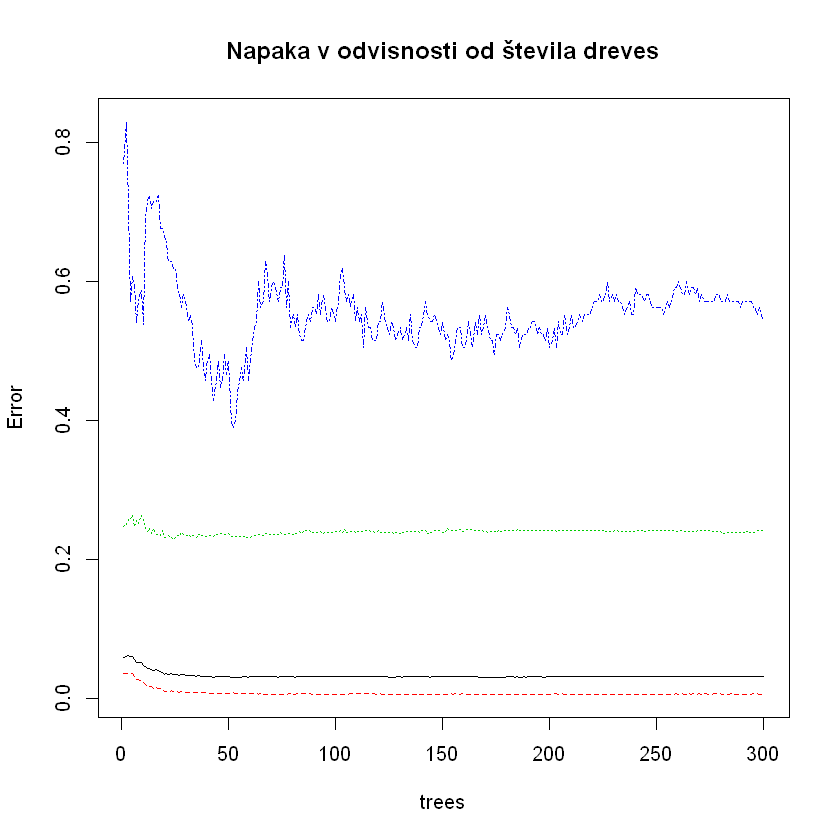

In [35]:
plot(rf, main="Napaka v odvisnosti od števila dreves")

In [34]:
rf1_5 <- randomForest(stanje ~ ., trainData, na.action = na.omit, ntree=50, mtry=10, proximity=TRUE)

In [9]:
print(rf1_5)


Call:
 randomForest(formula = stanje ~ ., data = trainData, ntree = 50,      mtry = 10, proximity = TRUE, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 10

        OOB estimate of  error rate: 2.95%
Confusion matrix:
      Good Bad Other class.error
Good  9568  18    44 0.006438214
Bad    191 597     3 0.245259166
Other   54   0    31 0.635294118


In [27]:
rf2 <- randomForest(stanje ~ ., trainData, na.action = na.omit, ntree=200, mtry=18, proximity=TRUE)

In [20]:
print(rf2)


Call:
 randomForest(formula = stanje ~ ., data = trainData, ntree = 200,      mtry = 18, proximity = TRUE, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 18

        OOB estimate of  error rate: 3.02%
Confusion matrix:
      Good Bad Other class.error
Good  9479  10    56 0.006914615
Bad    197 689     2 0.224099099
Other   53   0    52 0.504761905


Sedaj uporabim naučene modele za napoved stanja pri komitentih v "test" delu podatkov. Rezultati so na prvi pogled zadovoljivi, zagotovo pa bi se dani model, dalo še precej izboljšati. Spodbudno je, da model dobro prepozna komitente, ki spadajo v razred "Bad". Uspešnost tega razreda znaša približno 99%.

Pri obravnavi rezultatov analize se je potrebno zavedati tudi dejstva, da smo za napoved razreda "stanje" (oz. posredno loan_status) uporabili nekatere spremenljivke, ki so rezultat tega, kateremu razredu pripada komitent. Primer je naprimer spremenljivka "last payment data", v kateri je zajeta ključna informacija o tem ali komitent zamuja s plačili ali ne. Te informacije pa banka pred sklenitvijo kredita nima. Tako bi pravo uporabno vrednost model dobil, če bi znali le iz že vnaprej znanih spremenljivk (zaposlitev, namen kredita, zgodovina transakcij komitenta, št. računov komitenta...) napovedati v kateri razred spada. 

In [38]:
Pred <- predict(rf, newdata=testData)
table(Pred, testData$stanje)

       
Pred    Good  Bad Other
  Good  4037   95    21
  Bad      2  266     0
  Other   16    1    18

In [12]:
Pred <- predict(rf1_5, newdata=testData)
table(Pred, testData$stanje)

       
Pred    Good  Bad Other
  Good  4052   97    34
  Bad      2  260     0
  Other   15    1    24

Kot primer alternativne uporabe algortima Random forest, naredim še model za napoved obrestne mere iz preostalih spremenljivk. Tu gre za problem regresije (opravka imamo s številsko, recimo zvezno, spremenljivko) in ne klasifikacije kot prej. Natančnost modela je zelo visoka, povprečna napaka tako znaša le okoli 0.03 odstotne točke. To vidimo tudi iz grafa, saj se grafa dejanske in napovedane obrestne mere praktično prekrivata.

In [13]:
rf <- randomForest(int_rate ~ ., trainData, na.action = na.omit, ntree=200, mtry=20, proximity=TRUE)

In [29]:
print(rf)
#plot(rf)
#importance(rf)


Call:
 randomForest(formula = int_rate ~ ., data = trainData, ntree = 200,      mtry = 20, proximity = TRUE, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 20

          Mean of squared residuals: 0.03635169
                    % Var explained: 99.81


In [27]:
Pred <- predict(rf, newdata=testData)

test <- testData
test$napoved <- round(Pred, 2)
test <- test[,c("int_rate", "napoved")]

head(test)

int_rate,napoved
12.29,12.29
8.39,8.43
6.24,6.24
6.03,6.03
24.08,24.07
10.99,10.99


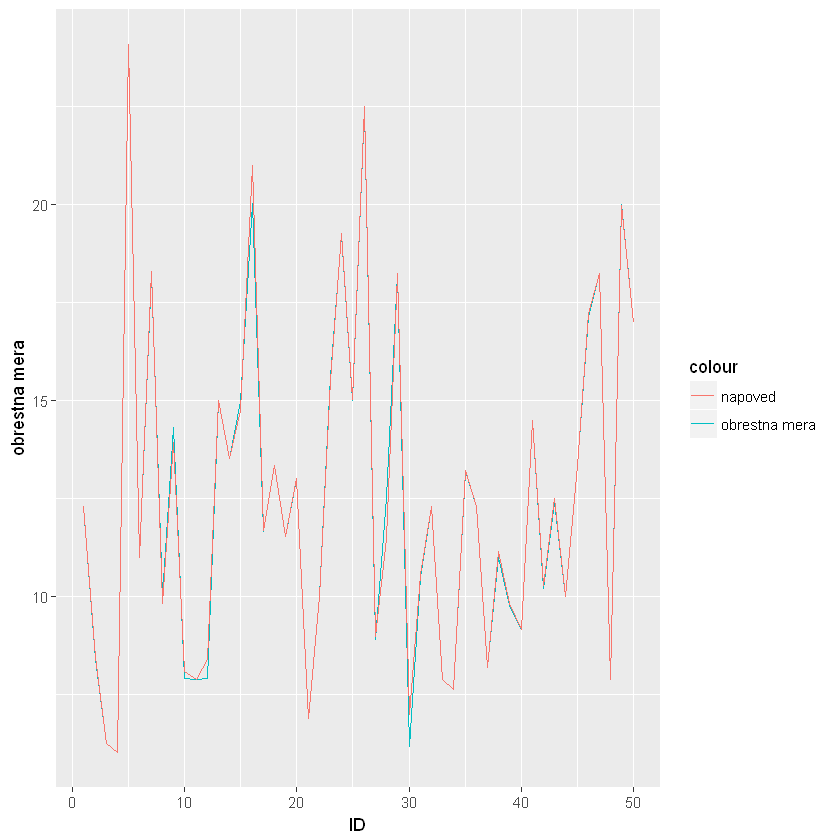

In [25]:
test$ID <- seq.int(nrow(test))
test <- test[1:50, ]

ggplot() +
  geom_line(data = test, aes(x = ID, y = int_rate, colour = "obrestna mera")) +
  geom_line(data = test, aes(x = ID, y = napoved,   colour = "napoved")) +
  ylab('obrestna mera')